In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [2]:
import torch
f = torch.as_tensor([1,1], dtype=torch.float32)
f = f.ger(f).unsqueeze(0).unsqueeze(1) / f.sum().square()
print(f.shape)

x = f.mul(4).tile([3, 1, 1, 1])
print(x.shape)

torch.Size([1, 1, 2, 2])
torch.Size([3, 1, 2, 2])


In [15]:
import jax.numpy as jnp
f = jnp.asarray([1,1], jnp.float32)
f = jnp.expand_dims(jnp.expand_dims(jnp.outer(f, f), -1), -1) / (f.sum() ** 2)
print(f.shape)

x = jnp.tile(f.__mul__(4), [1, 1, 1, 3])
print(x.shape)

(2, 2, 1, 1)
(2, 2, 1, 3)


In [16]:
x

Array([[[[1., 1., 1.]],

        [[1., 1., 1.]]],


       [[[1., 1., 1.]],

        [[1., 1., 1.]]]], dtype=float32)

In [26]:
import flax.linen as nn
import temp

gn_t = temp.GroupNorm(224)

x = torch.randn(2, 224, 56, 56)
t_out = gn_t(x).permute(0, 2, 3, 1).detach().numpy()

gn_f = nn.GroupNorm(epsilon=1e-5)
params = gn_t.state_dict()
params = {'params': {'scale': params['weight'].numpy(), 'bias': params['bias'].numpy()}}
f_out = gn_f.apply(params, x.permute(0, 2, 3, 1).numpy())

import numpy as np
np.testing.assert_almost_equal(f_out, t_out, decimal=5)

In [29]:
import jax.numpy as jnp
from jax import lax

X = jnp.array([[1, 2], [3, 4], [5, 6]])
Y = jnp.array([[2, 2], [4, 4]])

def pairwise_distance(x, y):
    return jnp.sqrt(jnp.sum((x[:,None,:]-y[None,:,:])**2, axis=-1))

pairwise_distance(X, Y)

Array([[1.       , 3.6055512],
       [2.236068 , 1.       ],
       [5.       , 2.236068 ]], dtype=float32)

In [30]:
import torch

A = torch.Tensor([[1, 2], [3, 4], [5, 6]])
B = torch.Tensor([[2, 2], [4, 4]])
torch.cdist(A, B)

tensor([[1.0000, 3.6056],
        [2.2361, 1.0000],
        [5.0000, 2.2361]])

In [40]:
M  = 1000
C_1 = 0.001
C_2 = 0.008
def alpha_bar(j):
    j = torch.as_tensor(j)
    return (0.5 * np.pi * j / M / (C_2 + 1)).sin() ** 2
u = torch.zeros(M + 1)
for j in range(M, 0, -1): # M, ..., 1
    u[j - 1] = ((u[j] ** 2 + 1) / (alpha_bar(j - 1) / alpha_bar(j)).clip(min=C_1) - 1).sqrt()


def round_sigma(sigma, return_index=False):
    sigma = torch.as_tensor(sigma)
    a = sigma.to(torch.float32).reshape(1, -1, 1)
    b = u.reshape(1, -1, 1)
    print(a.shape, b.shape)
    index = torch.cdist(a, b)
    print(index.shape)
    index = index.argmin(2)
    result = index if return_index else u[index.flatten()].to(sigma.dtype)
    return result.reshape(sigma.shape)

round_sigma(torch.ones(2, 1, 1, 1), True)

torch.Size([1, 2, 1]) torch.Size([1, 1001, 1])
torch.Size([1, 2, 1001])


tensor([[[[504]]],


        [[[504]]]])

In [69]:
from jax.scipy.spatial.distance import cdist

ModuleNotFoundError: No module named 'jax.scipy.spatial'

In [73]:
x = torch.rand(1, 2, 1)
y = torch.rand(1, 1001, 1)
c = torch.cdist(x, y)

def cdist(array1, array2):
    # Reshape input arrays to have shape (m, d) and (n, d)
    array1 

    # Compute distance matrix using broadcasting
    expanded_array1 = jnp.broadcast_to(array1, (n,) + array1.shape)
    expanded_array2 = jnp.broadcast_to(array2, (m,) + array2.shape)
    distances = jnp.sqrt(jnp.sum(jnp.square(expanded_array1 - expanded_array2), axis=-1))

    # Reshape distances array to have shape (1, m, n)
    distances = jnp.reshape(distances, (1, m, n))

    return distances


d = cdist(x.numpy(), y.numpy())
print(c.shape, d.shape)
np.testing.assert_almost_equal(c.numpy(), d, decimal=7)

TypeError: 'tuple' object cannot be interpreted as an integer

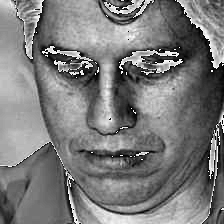

In [3]:
import temp
import augment
import torch
from torchvision import transforms
from PIL import Image
transform = transforms.Compose([
        transforms.ToTensor()
])
# Convert the image to Torch tensor

img = Image.open('/home/sreeraj/lab/datasets/fairface/val/55.jpg').convert('L')
img = transform(img)

images = img.unsqueeze(0)

args = {'xflip':0, 'yflip':0, 'rotate_int':0, 'translate_int':0, 'translate_int_max':0,
        'scale':0, 'rotate_frac':0, 'aniso':0, 'translate_frac':0, 'scale_std':0, 'rotate_frac_max':0, 'aniso_std':0, 'aniso_rotate_prob':0, 'translate_frac_std':0,
        'brightness':0, 'contrast':1, 'lumaflip':0, 'hue':0, 'saturation':1, 'brightness_std':0, 'contrast_std':2, 'hue_max':0, 'saturation_std':1,}

pipe = temp.AugmentPipe(**args)
imgs, lbls = pipe(images)

transform = transforms.ToPILImage()
transform(imgs[0])

In [4]:
import jax.numpy as jnp
import numpy as np
import jax

imgs = images.permute(0, 2, 3, 1).numpy()

pipe = augment.AugmentPipe(**args)
key = jax.random.PRNGKey(9)

/tmp/ipykernel_2433730/4180158813.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  transform(torch.from_numpy(np.asarray(jnp.transpose(imgs_f, (0, 3, 1, 2))))[0])


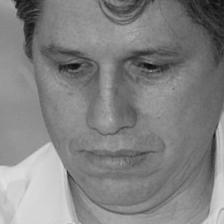

In [5]:
key, newkey = jax.random.split(key)
imgs_f, lbsl_f = pipe.apply({}, imgs, rngs={'augment': newkey})

transform(torch.from_numpy(np.asarray(jnp.transpose(imgs_f, (0, 3, 1, 2))))[0])

In [7]:
def linspace_from_neg_one(grid, num_steps, align_corners):
    if num_steps <= 1:
        return 0
    range = jnp.linspace(-1, 1, num_steps)
    if not align_corners:
        range = range * (num_steps - 1) / num_steps
    return range

def make_base_grid_4D(theta, N, C, H, W, align_corners):
    base_grid = jnp.empty((N, H, W, 3))
    base_grid = base_grid.at[..., 0].set(linspace_from_neg_one(theta, W, align_corners))
    base_grid = base_grid.at[..., 1].set(jnp.expand_dims(linspace_from_neg_one(theta, H, align_corners), -1))
    base_grid = base_grid.at[..., 2].set(jnp.full_like(base_grid[..., 2], 1))
    return base_grid

def make_base_grid_5D(theta, N, C, D, H, W, align_corners):
    base_grid = jnp.empty((N, D, H, W, 4))
    base_grid = base_grid.at[..., 0].set(linspace_from_neg_one(theta, W, align_corners))
    base_grid = base_grid.at[..., 1].set(jnp.expand_dims(linspace_from_neg_one(theta, H, align_corners), -1))
    base_grid = base_grid.at[..., 2].set(jnp.expand_dims(jnp.expand_dims(linspace_from_neg_one(theta, D, align_corners), -1), -1))
    base_grid = base_grid.at[..., 3].set(jnp.full_like(base_grid[..., 3], 1))
    return base_grid

def affine_grid_generator_4D(theta, N, C, H, W, align_corners):
    base_grid = make_base_grid_4D(theta, N, C, H, W, align_corners)
    grid = jnp.matmul(jnp.reshape(base_grid, (N, H * W, 3)), jnp.transpose(theta, (0, 2, 1)))
    return jnp.reshape(grid, (N, H, W, 2))

def affine_grid_generator_5D(theta, N, C, D, H, W, align_corners):
    base_grid = make_base_grid_5D(theta, N, C, D, H, W, align_corners)
    grid = jnp.matmul(jnp.reshape(base_grid, (N, D * H * W, 4)), jnp.transpose(theta, (0, 2, 1, 3)))
    return jnp.reshape(grid, (N, D, H, W, 3))

def affine_grid_generator(theta, size, align_corners):
    print(size)
    if len(size) != 4 and len(size) != 5:
        raise ValueError('AffineGridGenerator needs 4d (spatial) or 5d (volumetric) inputs')
    if len(size) == 4:
        return affine_grid_generator_4D(theta, size[0], size[1], size[2], size[3], align_corners)
    else:
        return affine_grid_generator_5D(theta, size[0], size[1], size[2], size[3], size[4], align_corners)
        

In [8]:
import torch
import numpy as np
theta = torch.rand(2, 2, 3)
size = (2, 3, 224, 224)
grid = torch.nn.functional.affine_grid(theta, size, False)

theta = theta.numpy()

grid_j = affine_grid_generator(theta, size, False)

np.testing.assert_almost_equal(grid.numpy(), grid_j, decimal=6)

(2, 3, 224, 224)


In [9]:
input_tensorimages = torch.rand(2, 3, 224, 224)
out_t = torch.nn.functional.grid_sample(images, grid, mode='bilinear', padding_mode='zeros', align_corners=False)

from jax.scipy.ndimage import map_coordinates

print(images.shape, grid_j.shape)
out_j = map_coordinates(images.numpy(), jnp.reshape(grid_j, ), order=1, cval=0)

RuntimeError: grid_sampler(): expected grid and input to have same batch size, but got input with sizes [1, 1, 224, 224] and grid with sizes [2, 224, 224, 2]

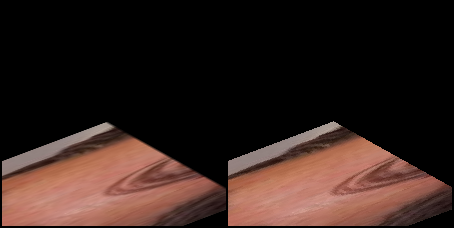

In [13]:
import torch
from scipy.ndimage import map_coordinates
import temp
import augment
import torch
from torchvision import transforms
from PIL import Image
import jax
import jax.numpy as jnp

# Define a function to test the `map_coordinates` implementation
def test_map_coordinates():
    # Example input tensor
    
    # Convert the image to Torch tensor
    transform = transforms.Compose([
            transforms.ToTensor()
    ])
    img = Image.open('/home/sreeraj/lab/datasets/fairface/val/55.jpg')#.convert('L')
    img = transform(img)

    input_tensor = img.unsqueeze(0)

    # Example batch of affine transformation matrices
    batch_size = input_tensor.shape[0]
    affine_matrices = torch.randn(batch_size, 2, 3)

    # Generate spatial transformation grids using affine_grid
    spatial_transform_grid = torch.nn.functional.affine_grid(affine_matrices, input_tensor.size())
    expected_output_tensor = torch.nn.functional.grid_sample(input_tensor, spatial_transform_grid)

    spatial_transform_grid = jnp.asarray(spatial_transform_grid.numpy())
    spatial_transform_grid = jnp.transpose(spatial_transform_grid, (0, 3, 1, 2))
    spatial_transform_grid = spatial_transform_grid.at[:, [1, 0]].set((spatial_transform_grid.at[:, [0, 1]].get() + 1)/2)
    spatial_transform_grid = jnp.round(spatial_transform_grid * 224)

    # Apply map_coordinates to input tensor using spatial transformation grid
    input_tensor = jnp.asarray(input_tensor.permute(0, 2, 3, 1).numpy())
    output_tensor = jnp.zeros_like(input_tensor)
    for i in range(batch_size):
        for j in range(input_tensor.shape[3]):
            output_tensor = output_tensor.at[i, :, :, j].set(jax.scipy.ndimage.map_coordinates(input_tensor[i, :,:, j], spatial_transform_grid[i], order=1))

    output_tensor = torch.tensor(np.asarray(output_tensor)).permute(0, 3, 1, 2)
    return expected_output_tensor[0], output_tensor[0]

transform = transforms.ToPILImage()

from torchvision.utils import make_grid
# Call the testing function
out = test_map_coordinates()
transform(make_grid(list(out), 2))


In [14]:
transform = transforms.Compose([
            transforms.ToTensor()
    ])
img = Image.open('/home/sreeraj/lab/datasets/fairface/val/55.jpg')#.convert('L')
img = transform(img)

affine_matrices = torch.randn(256, 2, 3).cuda()
input_tensor = img.unsqueeze(0).repeat([256, 1, 1, 1]).cuda()
grid = torch.nn.functional.affine_grid(theta=affine_matrices, size=input_tensor.shape, align_corners=False)

In [17]:
def affine_transform_p(images, grid):
    expected_output_tensor = torch.nn.functional.grid_sample(images, grid)
    torch.cuda.synchronize()
    return expected_output_tensor

%timeit -n 100 affine_transform_p(input_tensor, grid)

3.07 ms ± 49.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
input_tensor = jax.device_put(jnp.asarray(input_tensor.permute(0, 2, 3, 1).cpu().numpy()))
grid = jax.device_put(jnp.asarray(grid.cpu().numpy()))

In [610]:
def affine_transform_j(input_tensor, spatial_transform_grid):
    batch_size = input_tensor.shape[0]
    spatial_transform_grid = jnp.transpose(spatial_transform_grid, (0, 3, 1, 2))
    spatial_transform_grid = spatial_transform_grid.at[:, [1, 0]].set((spatial_transform_grid.at[:, [0, 1]].get() + 1)*224/2)

    # Apply map_coordinates to input tensor using spatial transformation grid
    output_tensor = jnp.zeros_like(input_tensor)
    for i in range(batch_size):
        for j in range(input_tensor.shape[3]):
            output_tensor = output_tensor.at[i, :, :, j].set(jax.scipy.ndimage.map_coordinates(input_tensor[i, :,:, j], spatial_transform_grid[i], order=1))
    return output_tensor

affine_transform_j_jit = jax.jit(affine_transform_j)

%timeit -n 10 affine_transform_j_jit(input_tensor, grid).block_until_ready()

(256, 2, 224, 224)
The slowest run took 91.24 times longer than the fastest. This could mean that an intermediate result is being cached.
1.54 s ± 3.51 s per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
def affine_transform_v(input_tensor, spatial_transform_grid):
    spatial_transform_grid = jnp.transpose(spatial_transform_grid, (0, 3, 1, 2))
    print(spatial_transform_grid.shape)
    spatial_transform_grid = spatial_transform_grid.at[:, [1, 0]].set((spatial_transform_grid.at[:, [0, 1]].get() + 1)*224/2)

    # spatial_transform_grid = jnp.swapaxes(spatial_transform_grid, 0, 1)[:, ::-1]
    # spatial_transform_grid = (spatial_transform_grid + 1) * 224 / 2

    a = lambda x, y: jax.scipy.ndimage.map_coordinates(x[:,:], y, order=1)
    a_v = jax.vmap(jax.vmap(a, in_axes=[-1, None], out_axes=-1))
    return a_v(input_tensor, spatial_transform_grid)

affine_transform_v_jit = jax.jit(affine_transform_v)
test_grid = affine_grid_generator(jnp.asarray(affine_matrices.cpu().numpy()), (256, 2, 224, 224), align_corners=False)
%timeit -n 100 affine_transform_v_jit(input_tensor, test_grid).block_until_ready()

(256, 2, 224, 224)
(256, 2, 224, 224)


TypeError: unsupported operand type(s) for +: '_IndexUpdateRef' and 'int'

In [623]:
%timeit -n 100 affine_transform_v_jit(input_tensor, test_grid).block_until_ready()

2.1 ms ± 276 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [606]:
# Cuda 12.5 us
# CPU 631 us

# Without JIT 14.4 ms
# With JIT 90 us
# With JIT and vmap 46 us
imgs= affine_transform_j_jit(input_tensor, grid)
transforms.ToPILImage()(torch.tensor(np.asarray(imgs)).permute(0, 3, 1, 2)[0])
np.testing.assert_almost_equal(np.asarray(affine_transform_v_jit(input_tensor, grid)), np.asarray(affine_transform_j_jit(input_tensor, grid)), decimal=6)